# Laplace Equation with RBF-PINN

In [31]:
%reset -f

In [32]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state, checkpoints
import optax
import os

from updec import *

## Building a normal PINN first

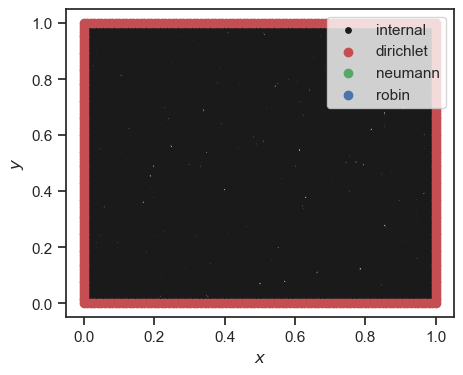

In [33]:
RBF = polyharmonic
MAX_DEGREE = 4

facet_types={"south":"d", "west":"d", "north":"d", "east":"d"}
cloud = SquareCloud(Nx=100, Ny=100, facet_types=facet_types, noise_seed=42, support_size=1*11-1)

xy = cloud.sort_nodes_jnp()

cloud.visualize_cloud(figsize=(5,4));

In [34]:
class PINN(nn.Module):
    @nn.compact
    def __call__(self, x, y):
        in_data = jnp.stack([x, y], axis=-1)
        y = nn.Dense(50)(in_data)
        for _ in range(0, 3):
            y = nn.tanh(y)
            y = nn.Dense(50)(y)
        return nn.Dense(1)(y)[0]

def init_flax_params(net:nn.Module):
    key = jax.random.PRNGKey(5)
    init_data = jnp.ones((1,)), jnp.ones((1,))
    params = net.init(key, *init_data)
    print(net.tabulate(key, *init_data, depth=8, console_kwargs={"force_jupyter":False}))
    return params

pinn = PINN()
params = init_flax_params(pinn)


                                PINN Summary                                 
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs        ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ PINN   │ - float32[1]  │ float32[1]    │                        │
│         │        │ - float32[1]  │               │                        │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,2]  │ float32[1,50] │ bias: float32[50]      │
│         │        │               │               │ kernel: float32[2,50]  │
│         │        │               │               │                        │
│         │        │               │               │ 150 (600 B)            │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,50] │ float32[1,50] │ bias: floa

## Define boundary conditions

In [35]:
# Boundary data
north_nodes = [cloud.nodes[i] for i in cloud.facet_nodes["north"]]
xy_n = jnp.stack(north_nodes, axis=-1).T
u_n = jnp.sin(jnp.pi * xy_n[:, 0])

sew_nodes = [cloud.nodes[i] for i in cloud.facet_nodes["south"]+cloud.facet_nodes["east"]+cloud.facet_nodes["west"]]
xy_sew = jnp.stack(sew_nodes, axis=-1).T
u_sew = jnp.zeros_like(xy_sew[:, 0])

In [36]:
# Physical data inside of domain
internal_nodes = [cloud.nodes[i] for i in cloud.nodes.keys() if cloud.node_boundary_types[i]=="i"]
xy_i = jnp.stack(internal_nodes, axis=-1).T

## Training

In [37]:
@jax.grad
def u_x(x, y, params):
    return pinn.apply(params, x, y)

@jax.grad
def u_y(y, x, params):
    return pinn.apply(params, x, y)

@jax.grad
def u_xx(x, y, params):
    return u_x(x, y, params)

@jax.grad
def u_yy(y, x, params):
    return u_y(y, x, params)

## Vectorise everything that's usefull
vmapped_u = jax.vmap(pinn.apply, in_axes=(None, 0, 0), out_axes=0)
vmapped_u_xx = jax.vmap(u_xx, in_axes=(0, 0, None), out_axes=0)
vmapped_u_yy = jax.vmap(u_yy, in_axes=(0, 0, None), out_axes=0)

def residual(params, x, y):
    """ Physics-based loss function for Laplace equation """
    u_xx_ = vmapped_u_xx(x, y, params)
    u_yy_ = vmapped_u_yy(y, x, params)
    return u_xx_ + u_yy_

def loss_fn(params, xy_n, u_n, xy_sew, u_sew, xy_i):
    u_n_pred = vmapped_u(params, xy_n[:,0], xy_n[:,1])
    loss_n = optax.l2_loss(u_n_pred - u_n)        ## Data loss north

    u_sew_pred = vmapped_u(params, xy_sew[:,0], xy_sew[:,1])
    loss_sew = optax.l2_loss(u_sew_pred - u_sew)        ## Data loss south, west, and east

    res = residual(params, xy_i[:,0], xy_i[:,1])
    loss_i = optax.l2_loss(res)                    ## Residual loss

    eps_n, eps_sew = 1e-0, 1e-0
    return jnp.mean(loss_i) + eps_n*jnp.mean(loss_n) + eps_sew*jnp.mean(loss_sew)

grad_loss_fn = jax.grad(loss_fn)

@jax.jit
def train_step(state, xy_n, u_n, xy_sew, u_sew, xy_i):
    grads = grad_loss_fn(state.params, xy_n, u_n, xy_sew, u_sew, xy_i)
    state = state.apply_gradients(grads=grads)
    loss = loss_fn(state.params, xy_n, u_n, xy_sew, u_sew, xy_i)
    return state, loss

In [38]:
## Optimizer
scheduler = optax.linear_schedule(init_value=1e-3, end_value=1e-5, transition_steps=60001)
optimizer = optax.sgd(learning_rate=scheduler)

## Flax training state
state = train_state.TrainState.create(apply_fn=pinn.apply,
                                        params=params,
                                        tx=optimizer)

In [39]:
EPOCHS = 6001
history_loss = []   # data for plotting

if os.path.isfile("./temp/pinn_checkpoint_"+str(state.step)):
    print("Found existing network, loading & training from step", state.step)
    state = checkpoints.restore_checkpoint(ckpt_dir="./temp/", prefix="pinn_checkpoint_", target=state)
else:
    print("Training from scratch")

for epoch in range(EPOCHS+1):
    state, loss = train_step(state, xy_n, u_n, xy_sew, u_sew, xy_i)
    history_loss.append(loss)

    if epoch<3 or epoch%1000==0:
        print("Epoch: %-5d                Loss: %.6f" % (epoch, loss))

checkpoints.save_checkpoint("./temp/", prefix="pinn_checkpoint_", target=state, step=state.step, overwrite=True)
print("Training done, saved network")

Training from scratch
Epoch: 0                    Loss: 0.306408
Epoch: 1                    Loss: 0.293182
Epoch: 2                    Loss: 0.282515
Epoch: 1000                 Loss: 0.112292
Epoch: 2000                 Loss: 0.100483
Epoch: 3000                 Loss: 0.093518
Epoch: 4000                 Loss: 0.088839
Epoch: 5000                 Loss: 0.085438
Epoch: 6000                 Loss: 0.082856
Training done, saved network


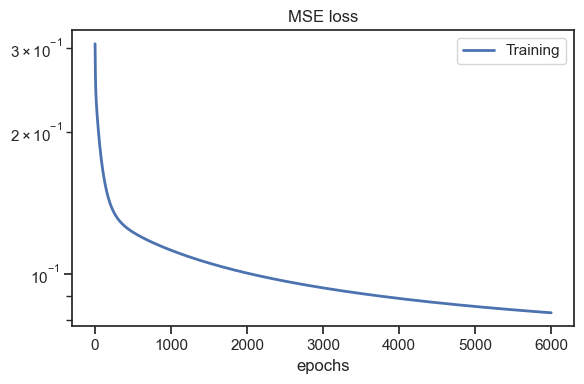

In [40]:
ax = plot(history_loss, label='Training', x_label='epochs', title='MSE loss', figsize=(6,4), y_scale="log")

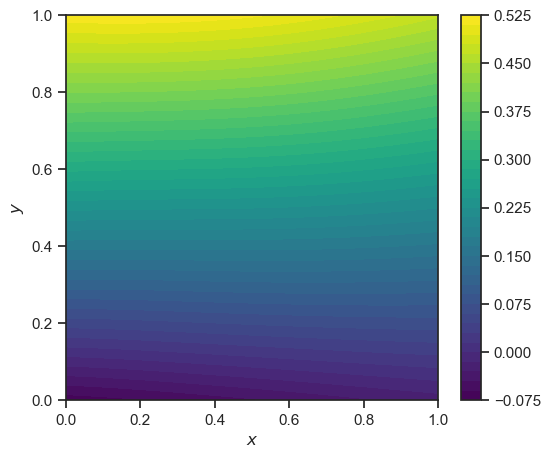

In [41]:
u_sol = vmapped_u(state.params, xy[:, 0], xy[:, 1])
cloud.visualize_field(u_sol, cmap="viridis", projection="2d", ax=None, figsize=(6,5));
# cloud.visualize_field(u_sol, cmap="viridis", projection="3d", ax=None, figsize=(10,10));

## Evaluation

## Findings


## Next steps
